# Neural Network
Time to create an NN that will (hopefully) perform much better than a support vector machine. I intend to use a simple deep neural network.


### Goals 
- refresh myself on creating a straightforward neural network using pytorch
- gain insight on the performance of a basic NN
- perform hyperparameter tuning

### Results
- First attempt involves an nn with`4` hidden layers. Even using class weighting, I can't get the model to predict a 'true' or ictal state. This was the same issue I face with the SVM, leading to a misleading high accuracy. When you uncover some other metrics (recall, precision, F-1) it's clear to see that the model just predicts 0, and there are only false negatives.


### Notes


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd
import extraction
import importlib
from collections import Counter

import seaborn as sns
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report

from extraction.LT import LTPipeline
importlib.reload(extraction.LT) # bc I keep updating LTPipeine, this ensures the ipynb cache updates
from extraction.tools import get_all_edf_files_for_patient

### Data prep

In [7]:
# pipeline
files = get_all_edf_files_for_patient('chb01')
# files.extend(get_all_edf_files_for_patient('chb02'))
# files.extend(get_all_edf_files_for_patient('chb03'))
files.extend(['chb15_06.edf'])   # manually add one file that will be validation data

# print(files)
pipeline = LTPipeline(files)  

# TODO: processing multiple files in parallel doesn't seem to help like I think it would... I might have to do some timing/fixing on this
X_train, X_test, y_train, y_test = pipeline.train_test_split(validation_patient_id='chb15')


2025-07-04 00:12:39,044 - INFO - 43 total file(s) in pipeline!


******************** Train Test Split results ********************
X_train shape: (116748, 345)
X_test shape: (2879, 345)
y_train shape: (116748,)
y_test shape: (2879,)


In [47]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [48]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)    # long = 64-bit int
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# wrap X, y together
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders for easier training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # purposely shuffling train data set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # test dataset is always doing 'leave one patient out'

### NN 1
- 4 hidden layers

In [49]:
# model architecture
class ChbMitNN(nn.Module):
    def __init__(self):
        super(ChbMitNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(345, 450)  # 345 features
        self.fc2 = nn.Linear(450, 600)
        self.fc3 = nn.Linear(600, 500)
        self.fc4 = nn.Linear(500, 350)
        self.fc5 = nn.Linear(350, 100)
        self.fc6 = nn.Linear(100, 2)  # binary classification

        # dropout for generalization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)     

        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        x = F.relu(self.fc5(x))
        x = self.dropout(x)

        x = self.fc6(x)

        return x

In [76]:
# instantiate model, define loss function, define optimizer, move to gpu (if available)
model = ChbMitNN()

# manually calculate inverse frequency weights for class weighting
counts = Counter(y_train_tensor.tolist())
total = sum(counts.values())
weight0 = total / (2 * counts[0])
weight1 = total / (2 * counts[1])

weights = torch.tensor([weight0, weight1], dtype=torch.float32).to(device) # bc our dataset is so skewed to inter-ictal, heavily weight for ictal states
loss_func = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

ChbMitNN(
  (fc1): Linear(in_features=345, out_features=450, bias=True)
  (fc2): Linear(in_features=450, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=350, bias=True)
  (fc5): Linear(in_features=350, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [77]:
# training loop
num_epochs = 25
training_losses = [] 
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Track the loss for each epoch

    for i, data in enumerate(train_loader, 0):
        # 1. get a batch of data, move to proper device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 2. reset gradients (aside from first iteration, these have some value)
        optimizer.zero_grad()

        # 3. run the data through the model, get predictions. forward pass
        y_pred = model(inputs)

        # 4. Compute the loss
        loss = loss_func(y_pred, labels)

        # 5. Backpropagation
        loss.backward()

        # 6. update weights
        optimizer.step()

        training_losses.append(loss.item())
        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

end_time = time.time() 
total_training_time = end_time - start_time  # Calculate total training time

print(f'Done. Total Training Time: {total_training_time:.2f}s')

Epoch 1, Batch 100, Loss: 0.773
Epoch 1, Batch 200, Loss: 0.333
Epoch 1, Batch 300, Loss: 0.159
Epoch 1, Batch 400, Loss: 0.267
Epoch 1, Batch 500, Loss: 0.390
Epoch 1, Batch 600, Loss: 0.138
Epoch 1, Batch 700, Loss: 0.092
Epoch 1, Batch 800, Loss: 0.517
Epoch 1, Batch 900, Loss: 0.501
Epoch 1, Batch 1000, Loss: 0.226
Epoch 1, Batch 1100, Loss: 0.132
Epoch 1, Batch 1200, Loss: 0.335
Epoch 1, Batch 1300, Loss: 0.333
Epoch 1, Batch 1400, Loss: 0.468
Epoch 1, Batch 1500, Loss: 0.208
Epoch 1, Batch 1600, Loss: 0.176
Epoch 1, Batch 1700, Loss: 0.092
Epoch 1, Batch 1800, Loss: 0.068
Epoch 2, Batch 100, Loss: 0.663
Epoch 2, Batch 200, Loss: 0.247
Epoch 2, Batch 300, Loss: 0.588
Epoch 2, Batch 400, Loss: 0.094
Epoch 2, Batch 500, Loss: 0.264
Epoch 2, Batch 600, Loss: 0.224
Epoch 2, Batch 700, Loss: 0.262
Epoch 2, Batch 800, Loss: 0.314
Epoch 2, Batch 900, Loss: 0.256
Epoch 2, Batch 1000, Loss: 0.929
Epoch 2, Batch 1100, Loss: 0.175
Epoch 2, Batch 1200, Loss: 0.066
Epoch 2, Batch 1300, Loss: 0

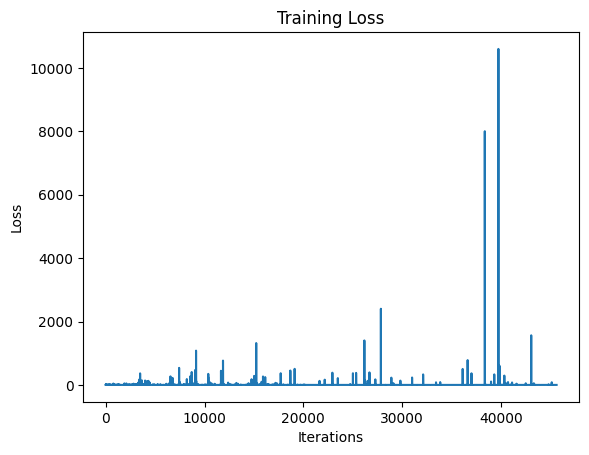

In [78]:
df_loss = pd.DataFrame({'iteration': range(1, len(training_losses) + 1), 'loss': training_losses})
sns.lineplot(df_loss, x='iteration', y='loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [80]:
# evaluate model accuracy
def evaluate(data_loader):
    correct = 0
    total = 0
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)  # Get predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

print(f"Train Accuracy: {evaluate(train_loader):.2f}%")    
print(f"Test Accuracy: {evaluate(test_loader):.2f}%")    

Train Accuracy: 99.69%
Test Accuracy: 96.46%


In [81]:
y_pred_labels = torch.argmax(model(X_test_tensor.to(device)), dim=1).cpu()
print(classification_report(y_test_tensor, y_pred_labels, digits=4))

              precision    recall  f1-score   support

           0     0.9646    1.0000    0.9820      2777
           1     0.0000    0.0000    0.0000       102

    accuracy                         0.9646      2879
   macro avg     0.4823    0.5000    0.4910      2879
weighted avg     0.9304    0.9646    0.9472      2879



/home/kimbo/github-repos/chb-mit-scalp-eeg/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kimbo/github-repos/chb-mit-scalp-eeg/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kimbo/github-repos/chb-mit-scalp-eeg/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [82]:
# inspecting logits for seeing why 
print(f"Logits (first 5): {y_pred[:5].detach().cpu().numpy()}")
print(f"Predictions: {torch.argmax(y_pred, dim=1)[:5]}")
print(f"True labels: {labels[:5]}")

Logits (first 5): [[ 2.5422907e-01 -2.1144073e-01]
 [-1.3077927e+02 -3.8559232e+02]
 [-8.8514938e+01 -2.6128925e+02]
 [-2.7620047e+02 -8.1328876e+02]
 [ 2.5422907e-01 -2.1144073e-01]]
Predictions: tensor([0, 0, 0, 0, 0], device='cuda:0')
True labels: tensor([0, 0, 0, 0, 0], device='cuda:0')
